In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
# GPU ÏÑ§Ï†ï
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")  # GPU ÏÇ¨Ïö© Í∞ÄÎä•ÌïòÎ©¥ cuda, ÏóÜÏúºÎ©¥ cpu

print(f"ÌòÑÏû¨ ÏÇ¨Ïö© Ï§ëÏù∏ ÎîîÎ∞îÏù¥Ïä§: {device}")
if use_cuda:
    print(f"GPU Ï†ïÎ≥¥: {torch.cuda.get_device_name(0)}")

ÌòÑÏû¨ ÏÇ¨Ïö© Ï§ëÏù∏ ÎîîÎ∞îÏù¥Ïä§: cuda
GPU Ï†ïÎ≥¥: NVIDIA A100-SXM4-40GB


In [ ]:
# Dataset Path
train_dir = '/content/drive/MyDrive/kaggle/Fruits_and_Vegetables_Image_Recognition/train'
test_dir = '/content/drive/MyDrive/kaggle/Fruits_and_Vegetables_Image_Recognition/test'
valid_dir = '/content/drive/MyDrive/kaggle/Fruits_and_Vegetables_Image_Recognition/validation'

In [ ]:
# png ÌååÏùºÏùò Ïù¥ÎØ∏ÏßÄ ÌòïÏãùÏù¥ PÎ™®ÎìúÎ°ú Ï†ÄÏû•ÎêòÏñ¥ÏûàÏñ¥ÏÑú Í≤ΩÍ≥† Î©îÏãúÏßÄÍ∞Ä Ï∂úÎ†•Îê® -> png ÌååÏùºÏùò ÌôïÏû•ÏûêÎ•º jpgÎ°ú Î≥ÄÍ≤Ω
def png_to_jpg(root_dir):
    for class_folder in os.listdir(root_dir):  # ÌÅ¥ÎûòÏä§ Ìè¥Îçî ÏàúÌöå
        class_path = os.path.join(root_dir, class_folder)

        # Ìè¥ÎçîÍ∞Ä ÏïÑÎãàÎ©¥ Ïä§ÌÇµ
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # ÌôïÏû•ÏûêÍ∞Ä .pngÏù∏ÏßÄ ÌôïÏù∏
            if img_path.lower().endswith(".png"):
                # Ïù¥ÎØ∏ÏßÄ Ïó¥Í∏∞
                try:
                    with Image.open(img_path) as img:
                        # RGBÎ°ú Î≥ÄÌôò ÌõÑ JPGÎ°ú Ï†ÄÏû•
                        img = img.convert("RGB")

                        # ÏÉàÎ°úÏö¥ JPG Í≤ΩÎ°ú
                        new_img_path = img_path.rsplit(".", 1)[0] + ".jpg"

                        img.save(new_img_path, "JPEG", quality=95)  # 95% ÌíàÏßà Ïú†ÏßÄ
                        print(f"Î≥ÄÌôò ÏôÑÎ£å: {img_path} ‚Üí {new_img_path}")

                        # Í∏∞Ï°¥ PNG ÏÇ≠Ï†ú
                        os.remove(img_path)

                except Exception as e:
                    print(f"Î≥ÄÌôò Ïã§Ìå®: {img_path} - {e}")

# Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Î≥ÄÌôò Ï†ÅÏö©
png_to_jpg(train_dir)
png_to_jpg(valid_dir)
png_to_jpg(test_dir)

print("PNG ‚Üí JPG Î≥ÄÌôò ÏÑ±Í≥µ")

PNG ‚Üí JPG Î≥ÄÌôò ÏÑ±Í≥µ


In [ ]:
# ResNet50ÏóêÏÑú ÏÇ¨Ïö©Ìï† Ïù¥ÎØ∏ÏßÄÎ°ú Î≥ÄÌôò
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNetÍ≥º ÎèôÏùºÌïú Ï†ÑÏ≤òÎ¶¨ Î∞©Ïãù ÏÇ¨Ïö© (ÎèôÏùºÌïú Ï†ïÍ∑úÌôî)
])

In [ ]:
# Dataset Load (ImageNet Ï†ÑÏ≤òÎ¶¨ Ï†ÅÏö©)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [ ]:
# DataLoader ÏÑ§Ï†ï / GPU Í∞ÄÏÜç ÏµúÏ†ÅÌôî
# Ïã§Ìñâ ÏÜçÎèÑÍ∞Ä Ï°∞Í∏à ÎäêÎ†§ÏßÄÎ©¥, num_workersÏùò Í∞íÏùÑ Ï§ÑÏó¨ÏÑú Ï†ÄÏû• -> ÎäêÎ†§Ï†∏ÏÑú 4ÏóêÏÑú 0Î°ú Î≥ÄÍ≤Ω
# Ïã§Ìñâ ÏÜçÎèÑÍ∞Ä ÎäêÎ†§ÏßÑÎã§Î©¥, batch_size Í∞íÏùÑ Ï§ÑÏó¨ÏÑú Ï†ÄÏû• -> 32ÏóêÏÑú 16ÏúºÎ°ú Ï§ÑÏûÑ
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
print(f"Train Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {len(train_dataset)}")       # ÌÅ¥ÎûòÏä§ Îãπ ÏïΩ 100Ïû•
print(f"Validation Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {len(valid_dataset)}")  # ÌÅ¥ÎûòÏä§ Îãπ ÏïΩ 10Ïû•
print(f"Test Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {len(test_dataset)}")         # ÌÅ¥ÎûòÏä§ Îãπ ÏïΩ 10Ïû•

Train Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 3115
Validation Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 351
Test Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 359


In [ ]:
# ÌÅ¥ÎûòÏä§ ÎùºÎ≤® ÌôïÏù∏
print(f'ÌÅ¥ÎûòÏä§ Í∞úÏàò : {len(test_dataset.classes)}')
print(f'ÌÅ¥ÎûòÏä§ Î™©Î°ù : {test_dataset.classes}')

ÌÅ¥ÎûòÏä§ Í∞úÏàò : 36
ÌÅ¥ÎûòÏä§ Î™©Î°ù : ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


-----------------
=== ResNet50 ===

    - Fully Connected (FC) Layer ÌïôÏäµ Í∞ÄÎä•ÌïòÎèÑÎ°ù ÏÑ§Ï†ï
    - Conv LayerÏùò ÏùºÎ∂Ä Layer4Îßå ÌïôÏäµ Í∞ÄÎä•ÌïòÎèÑÎ°ù ÏÑ§Ï†ï

In [ ]:
# ÏÇ¨Ï†Ñ ÌïôÏäµÎêú ResNet50 Î∂àÎü¨Ïò§Í∏∞
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# ResNet50Ïùò Í∏∞Î≥∏ FC LayerÎäî 1000Í∞ú ÌÅ¥ÎûòÏä§ Î∂ÑÎ•òÏö©Ïù¥ÎØÄÎ°ú, 36Í∞úÏóê ÎßûÍ≤å ÏÉàÎ°úÏö¥ FC LayerÎ•º Ï∂îÍ∞ÄÌï¥Ïïº Ìï®
# Í∏∞Ï°¥ FC LayerÎ•º ÏÉàÎ°úÏö¥ ÌÅ¥ÎûòÏä§Î°ú Î≥ÄÍ≤Ω
# num_classes = len(train_dataset.classes) # 36Í∞ú

# ÏùºÎ∂Ä Î™®Îç∏ Ïª§Ïä§ÌÖÄ ÏßÑÌñâ
model.fc = nn.Sequential(
    nn.Linear(2048, 512),           # Í∏∞Ï°¥ Ï∂úÎ†• ÌÅ¨Í∏∞Îäî 2048
    nn.ReLU(),                      # ÌôúÏÑ±Ìôî Ìï®Ïàò
    nn.Dropout(0.3),                # Í≥ºÏ†ÅÌï© Î∞©ÏßÄÎ°ú Ï∂îÍ∞Ä : 0.5ÏóêÏÑú 0.3ÏúºÎ°ú Î≥ÄÍ≤Ω
    nn.Linear(512, 36)     # ÏµúÏ¢Ö Ï∂úÎ†• Í∞úÏàòÎ•º 36Í∞úÎ°ú Î≥ÄÍ≤Ω
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [ ]:
# Î™®Îì† Î†àÏù¥Ïñ¥Î•º ÌïôÏäµ Í∞ÄÎä•ÌïòÎèÑÎ°ù ÏÑ§Ï†ï
for param in model.parameters():
    param.requires_grad = True

# FC LayerÏôÄ Conv LayerÏùò Layer4Îßå ÌïôÏäµ Í∞ÄÎä•ÌïòÎèÑÎ°ù ÏÑ§Ï†ï
# Í∏∞Ï°¥ Feature Extractor Î∞©ÏãùÎ≥¥Îã§ Îçî Í∞ïÎ†•Ìïú Fine-TuningÏù¥ Í∞ÄÎä•Ìï®
# Í∞ÄÏ§ëÏπòÍ∞Ä ÎäòÏñ¥ÎÇòÏÑú ÏÑ±Îä• Ìñ•ÏÉÅ Í∞ÄÎä•
# ÌïòÏßÄÎßå Ï†ÑÏ≤¥ Conv LayerÎ•º ÌïôÏäµÏãúÌÇ§Îäî Í≤ÉÎ≥¥Îã§ ÌïôÏäµ ÏÜçÎèÑÍ∞Ä Îπ†Î¶Ñ
# ÏÇ¨Ï†Ñ ÌïôÏäµÎêú Í∞ÄÏ§ëÏπòÎ•º Ïú†ÏßÄÌïòÎ©¥ÏÑú, Í∞ÄÏû• Ï§ëÏöîÌïú Í≥†Ï∞®Ïõê ÌäπÏßïÏùÑ Ï∂îÍ∞ÄÏ†ÅÏúºÎ°ú ÌïôÏäµ Í∞ÄÎä• - Layer4
for name, param in model.named_parameters():
    if not name.startswith("layer4") and not name.startswith("fc"):
        param.requires_grad = False

In [ ]:
# Î™®Îç∏ GPUÎ°ú Ïù¥Îèô
model = model.to(device)

In [ ]:
# ÏÜêÏã§Ìï®Ïàò Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
# Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•òÏù¥ÎØÄÎ°ú CrossEntropyLoss ÏÇ¨Ïö©
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Conv LayerÎäî ÌïôÏäµÌïòÏßÄ ÏïäÍ≥†, FC LayerÎßå ÌïôÏäµÌïòÎØÄÎ°ú SGDÎßêÍ≥† Adam ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÇ¨Ïö©
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Ï∂îÍ∞Ä ÏÑ±Îä• Ìñ•ÏÉÅÏùÑ ÏúÑÌï¥ÏÑú AdamÏùÑ SGDÎ°ú Î≥ÄÍ≤Ω
# AdamWÎ°ú Î≥ÄÍ≤Ω : ÌïôÏäµ ÏÜçÎèÑÏôÄ ÏµúÏ†ÅÌôî ÏÜçÎèÑÍ∞Ä Îçî Îπ®ÎùºÏßà Ïàò ÏûàÏùå
# Learning RateÎ•º Ï§ÑÏûÑ -> Î™®Îç∏Ïù¥ ÌïôÏäµÏùÑ Ïûò ÌïòÍ≥† ÏûàÎäîÎç∞ ÏÑ±Îä•Ïù¥ Ï°∞Í∏à Ï†ïÏ≤¥ÎêòÍ±∞ÎÇò ÏßÑÎèôÌïòÎØÄÎ°ú, ÌïôÏäµÎ•†ÏùÑ Ï§ÑÏó¨ÏÑú ÏïàÏ†ïÏ†ÅÏù∏ ÏàòÎ†¥Ïù¥ Í∞ÄÎä•ÌïòÎèÑÎ°ù ÎßåÎì¨
# „Ñ¥ ÌïôÏäµÎ•† lr = 0.001 -> 0.0005 -> 0.0001Î°ú Ï§ÑÏûÑ
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [ ]:
# Ïä§ÏºÄÏ§ÑÎü¨ Ï†ÅÏö©
# Ïä§ÏºÄÏ§ÑÎü¨ : Î™®Îç∏Ïùò ÏÑ±Îä•Ïù¥ Ï†ïÏ≤¥ÎêòÎ©¥ ÏûêÎèôÏúºÎ°ú lrÎ•º Ï§ÑÏó¨Ï£ºÎäî Î∞©Ïãù
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
# ReduceLR0nPlateauÎ•º CosineAnnealingWarmRestartsÎ°ú Î≥ÄÍ≤Ω : Î≥¥Îã§ Î∂ÄÎìúÎüΩÍ≤å ÌïôÏäµÎ•†ÏùÑ Ï°∞Ï†àÌïòÎ©¥ÏÑú ÏÑ±Îä• Ìñ•ÏÉÅÏùÑ Ïú†ÎèÑÌï®
# Îß§ T_0 epochÎßàÎã§ ÌïôÏäµÎ•†Ïù¥ Î¶¨ÏÖãÎêòÎ©∞ ÎØ∏ÏÑ∏ Ï°∞Ï†ï Í∞ÄÎä•
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

- AMP(GridScaler) Ï†ÅÏö©
    - torch.cuda.amp.GradScaler() : Ïä§ÏºÄÏùºÎßÅ Ï†ÅÏö©
    - with torch.cuda.amp.autocast() : FP16 Ïó∞ÏÇ∞ ÌôúÏÑ±Ìôî
    - scaler.scale(loss).backward() : Gradient Scaling Ï†ÅÏö©
    - scaler.step(optimizer) -> scaler.update() Ïã§Ìñâ

In [ ]:
# Í≤ΩÍ≥† Î©îÏãúÏßÄ Ï∂úÎ†• ÏïàÌï®
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")

# ÏÑ±Îä• Í∏∞Î°ùÏùÑ ÏúÑÌïú Î¶¨Ïä§Ìä∏ Ï¥àÍ∏∞Ìôî ÏßÑÌñâ
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Early Stopping Í∏∞Ï§Ä Î≥ÄÏàò
best_valid_acc = 0          # ÏµúÍ≥†Ïùò Validation Ï†ïÌôïÎèÑÎ•º Ï†ÄÏû•
best_valid_loss = float("inf")
early_stopping_counter = 0
early_stopping_patience = 3  # 3Î≤à Ïó∞ÏÜç ÏÑ±Îä•Ïù¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ Î©àÏ∂§

epochs = 20
scaler = torch.amp.GradScaler("cuda")  # AMP : Mixed Precision ÌôúÏÑ±Ìôî

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # AMP Ï†ÅÏö© (Mixed Precision) : ÏÜçÎèÑ + Î©îÎ™®Î¶¨ Ìö®Ïú® ÎÜíÏûÑ
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Ïó≠Ï†ÑÌåå ÏàòÌñâ
        scaler.scale(loss).backward()   # loss Í∞íÏùÑ ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Ïä§ÏºÄÏùºÌï¥ÏÑú backward() Ìò∏Ï∂ú : ÏûëÏùÄ gradientÎì§Ïù¥ underflowÎêòÏßÄ ÏïäÍ≥† ÏïàÏ†ïÏ†ÅÏúºÎ°ú Ïó≠Ï†ÑÌåå Í∞ÄÎä•
        scaler.step(optimizer)          # Ïä§ÏºÄÏùºÎêú gradientÎ•º Í∏∞Ï§ÄÏúºÎ°ú optimizer stepÏùÑ ÏàòÌñâ : gradientÎ•º Ïä§ÏºÄÏùºÎêú Í∞íÏúºÎ°ú ÌÅ¥Î¶¨ÌïëÌïòÍ≥†, Îã§Ïãú Ïä§ÏºÄÏùºÏùÑ ÏõêÎûòÎåÄÎ°ú Î≥µÏõêÌïú ÌõÑ ÌååÎùºÎØ∏ÌÑ∞ ÏóÖÎç∞Ïù¥Ìä∏Î•º ÏßÑÌñâÌï®
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Train Loss Í≥ÑÏÇ∞
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validation ÏÑ±Îä• ÌèâÍ∞Ä
    model.eval()  # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ï†ÑÌôò
    correct, total, val_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:  # Validation Set ÏÇ¨Ïö©
            images, labels = images.to(device), labels.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = val_loss / len(valid_loader)
    valid_acc = 100 * correct / total  # Validation Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞

    # ReduceLR0nPlateauÏùÄ Validation LossÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÌïôÏäµÎ•† Ï°∞Ï†ï
    # scheduler.step(avg_valid_loss)  # Cosine Annealing Ï†ÅÏö©
    # CosineAnnealingWarmRestartsÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî Ïä§ÏºÄÏ§ÑÎü¨ Î∞©Ïãù Ï†ÅÏö© -> Cosine AnnealingÏùÄ metricÏóÜÏù¥ stepÎßå Ìò∏Ï∂ú
    scheduler.step(epoch + 1)

    # ÏÑ±Îä• Í∏∞Î°ù
    train_losses.append(avg_train_loss)
    val_losses.append(avg_valid_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(valid_acc)

    # Early Stopping
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        early_stopping_counter = 0  # ÏÑ±Îä• Í∞úÏÑ†ÎêòÎ©¥ Ïπ¥Ïö¥ÌÑ∞ Ï¥àÍ∏∞Ìôî
        best_valid_acc = valid_acc

        # Î™®Îç∏ Ï†ÄÏû•
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stopping_counter += 1  # ÏÑ±Îä• Í∞úÏÑ† Ïïà ÎêòÎ©¥ Ïπ¥Ïö¥Ìä∏ Ï¶ùÍ∞Ä
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early Stopping. Epoch {epoch+1}ÏóêÏÑú ÌïôÏäµ Ï¢ÖÎ£å")
            break

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Valid Loss: {avg_valid_loss:.4f}, "
          f"Train Accuracy: {train_acc:.2f}%, "
          f"Valid Accuracy: {valid_acc:.2f}%, "
          f"Time: {time.time() - start_time:.2f}s")

# Í≥ºÏ†ÅÌï©Ïù¥ ÏïÑÎãàÍ≥†, ÏùºÏãúÏ†ÅÏù∏ ÏÑ±Îä• ÌùîÎì§Î¶ºÏù¥ ÎÇòÌÉÄÎÇ®

Epoch [1/20], Train Loss: 2.1518, Valid Loss: 1.0588, Train Accuracy: 54.48%, Valid Accuracy: 88.03%, Time: 958.30s
Epoch [2/20], Train Loss: 1.1991, Valid Loss: 0.9729, Train Accuracy: 82.12%, Valid Accuracy: 91.45%, Time: 131.61s
Epoch [3/20], Train Loss: 1.0047, Valid Loss: 0.8908, Train Accuracy: 89.66%, Valid Accuracy: 96.01%, Time: 131.31s
Epoch [4/20], Train Loss: 0.8850, Valid Loss: 0.8579, Train Accuracy: 94.35%, Valid Accuracy: 95.44%, Time: 132.06s
Epoch [5/20], Train Loss: 0.8336, Valid Loss: 0.8460, Train Accuracy: 96.37%, Valid Accuracy: 96.01%, Time: 132.22s
Epoch [6/20], Train Loss: 0.9086, Valid Loss: 0.8789, Train Accuracy: 93.26%, Valid Accuracy: 95.44%, Time: 132.04s
Epoch [7/20], Train Loss: 0.8857, Valid Loss: 0.8352, Train Accuracy: 94.83%, Valid Accuracy: 96.87%, Time: 131.99s
Epoch [8/20], Train Loss: 0.8230, Valid Loss: 0.8328, Train Accuracy: 96.73%, Valid Accuracy: 96.87%, Time: 132.09s
Epoch [9/20], Train Loss: 0.7917, Valid Loss: 0.7933, Train Accuracy: 97

- Í≥ºÏ†ÅÌï©Ïù¥ ÎÇú Í≤ÉÏúºÎ°ú Î≥¥Ïù¥ÏßÄÎßå, early stoppingÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ best_model.pthÎäî Í∞ÄÏû• ÏÑ±Îä•Ïù¥ Ï¢ãÏùÄ ÏãúÏ†ê(epoch14)Ïùò Î™®Îç∏Î°ú Ï†ÄÏû•ÎêòÏñ¥ ÏûàÏùå.

-- Ï†ÑÌòÄ Í≥ºÏ†ÅÌï©Ïù¥ ÏïÑÎãàÎùº Î™®Îç∏Ïù¥ Ïûò ÏàòÎ†¥Ï§ëÏûÑÏùÑ Ïïå Ïàò ÏûàÏùå --

1.   Train LossÏôÄ Valid Loss Î™®Îëê ÎåÄÏ≤¥Î°ú ÏïàÏ†ïÏ†ÅÏúºÎ°ú Ï§ÑÏñ¥Îì§Í≥† ÏûàÏùå
2.   Ï§ëÍ∞ÑÏ§ëÍ∞Ñ Valid LossÍ∞Ä ÏÇ¥Ïßù Ïò¨ÎûêÎã§Í∞ÄÎèÑ Îã§Ïãú ÎÇ¥Î†§Í∞ê (Ï†ïÏÉÅÏ†ÅÏù∏ Ìå®ÌÑ¥)
3. Validation AccuracyÎèÑ Ï†êÏßÑÏ†ÅÏúºÎ°ú Ïò¨ÎùºÍ∞ê
4. Train AccÍ∞Ä Valid AccÎ≥¥Îã§ Ìõ®Ïî¨ ÎÜíÏïÑÏßÄÎäî ÌòÑÏÉÅÎèÑ ÏóÜÏùå -> Í≥ºÏ†ÅÌï© ÏïÑÎãò



In [ ]:
# ÏùºÏãúÏ†ÅÏúºÎ°ú GPUÏùò Î™®Îç∏ÏùÑ Íµ¨Í∏Ä ÎìúÎùºÏù¥Î∏åÏóê Ï†ÄÏû•ÌïòÏó¨ Îã§ÏùåÏóê Îã§Ïãú Î∂àÎü¨ÏôÄÏÑú ÏÇ¨Ïö©Ìï®
import shutil

# ColabÏùò ÌòÑÏû¨ ÏûëÏóÖ ÎîîÎ†âÌÜ†Î¶¨ÏóêÏÑú Íµ¨Í∏Ä ÎìúÎùºÏù¥Î∏åÎ°ú Î≥µÏÇ¨
shutil.copy("best_model.pth", "/content/drive/MyDrive/kaggle/best_model.pth")

In [ ]:
# Ï†ïÏÉÅÏ†ÅÏúºÎ°ú Î≥µÏÇ¨ÎêòÏóàÎäîÏßÄ ÌôïÏù∏ ÌïÑÏöî
import os

print(os.path.exists("/content/drive/MyDrive/kaggle/best_model.pth"))  # TrueÏù¥Î©¥ Î≥µÏÇ¨ ÏôÑÎ£å

True


In [ ]:
# ÌååÏùºÏù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú Ï†ÄÏû•Ïù¥ ÎêòÏóàÎäîÏßÄ ÌôïÏù∏ ÌïÑÏöî
import pickle

save_path = "/content/drive/MyDrive/kaggle/performance_data.pkl"

performance_data = {
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_losses': train_losses,
    'val_losses': val_losses
}

with open(save_path, 'wb') as f:
    pickle.dump(performance_data, f)

print("ÏÑ±Îä• Í∏∞Î°ù Ï†ÄÏû• ÏôÑÎ£å")

ÏÑ±Îä• Í∏∞Î°ù Ï†ÄÏû• ÏôÑÎ£å!


In [ ]:
# Îã§Ïãú Îü∞ÌÉÄÏûÑÏùÑ Ïó∞Í≤∞ÌïòÏó¨ ÏÇ¨Ïö©Ìï† Îïå, ÌååÏùºÏùÑ Î∂àÎü¨ÏôÄÏÑú ÏÇ¨Ïö©Ìï¥ÏïºÌï®.
import pickle

load_path = "/content/drive/MyDrive/kaggle/performance_data.pkl"

with open(load_path, 'rb') as f:
    data = pickle.load(f)

# Îã§Ïãú Î≥ÄÏàòÏóê Ìï†Îãπ
train_accuracies = data['train_accuracies']
val_accuracies = data['val_accuracies']
train_losses = data['train_losses']
val_losses = data['val_losses']

print("ÏÑ±Îä• Í∏∞Î°ù Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å")

ÏÑ±Îä• Í∏∞Î°ù Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å!


In [ ]:
# best_model.pthÎ•º ÏõêÌïòÎäî Í≤ΩÎ°úÏóê Ï†ÄÏû•
torch.save(model.state_dict(), "/content/drive/MyDrive/kaggle/best_model.pth")

In [ ]:
# Î™®Îç∏ Íµ¨Ï°∞ Ï†ïÏùò Î®ºÏ†Ä Ìï¥Ïïº Ìï® (model = resnet50(...) Í∞ôÏùÄ ÏΩîÎìú Î®ºÏ†Ä Ïã§Ìñâ ÌõÑ Ïù¥Î≤à ÏΩîÎìú Ïã§Ìñâ)
# Íµ¨Í∏Ä ÎìúÎùºÏù¥Î∏åÏóêÏÑú Î™®Îç∏ÏùÑ Í∞ÄÏ†∏Ïò§Îäî Í≤ΩÏö∞ Ïã§Ìñâ
model.load_state_dict(torch.load("/content/drive/MyDrive/kaggle/best_model.pth"))
model.to(device)
model.eval()

In [ ]:
# GPUÏóêÏÑú Ìï¥Îãπ Î™®Îç∏ Î∂àÎü¨ÏôÄÏÑú ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÏö∞ Ïã§Ìñâ
# Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
model.load_state_dict(torch.load("best_model.pth"))

# Î™®Îç∏ GPUÎ°ú Ïù¥Îèô
model.to(device)

# Î™®Îç∏ ÌèâÍ∞Ä
model.eval()

In [ ]:
# test dataset ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•
all_preds = []
all_labels = []

correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Î¶¨Ïä§Ìä∏Ïóê ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: {100 * correct / total:.2f}%")

ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: 97.49%


- 95%Î•º ÎÑòÍ∏∞Î©¥ Í±∞Ïùò ÏµúÏ†ÅÌôîÎêú ÏÉÅÌÉú
- ValidationÍ≥º Test Ï†ïÌôïÎèÑÍ∞Ä ÎπÑÏä∑Ìïú Í≤ÉÎèÑ Ï§ëÏöîÌï®
    - Í≥ºÏ†ÅÌï©Ïùò Î¨∏Ï†úÍ∞Ä Í±∞Ïùò ÏóÜÎã§Îäî Í≤ÉÏùÑ ÏùòÎØ∏
    > Î™®Îç∏Ïù¥ Ïûò ÏùºÎ∞òÌôî Îêú Í≤ÉÏúºÎ°ú ÌèâÍ∞Ä

-----------------
=== ÌïôÏäµ ÏãúÍ∞ÅÌôî ===


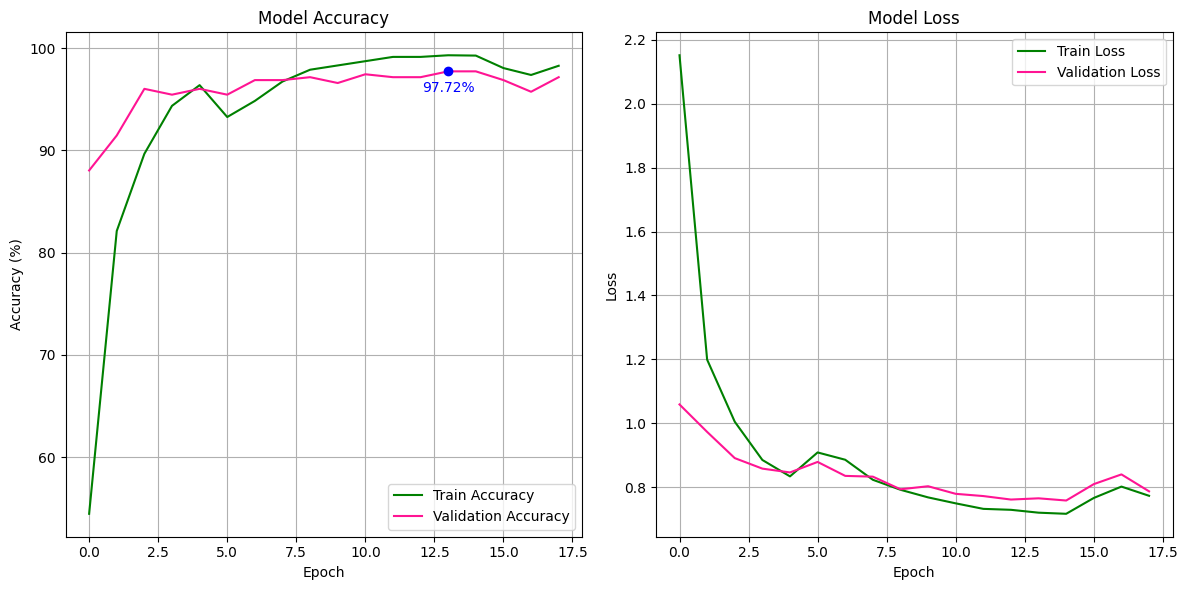

In [ ]:
# best Î™®Îç∏Ïù¥ Ï†ÄÏû•Îêú epoch index (Validation Accuracy Í∏∞Ï§Ä)
best_epoch = val_accuracies.index(max(val_accuracies))
best_val_acc = val_accuracies[best_epoch]

# Í∞ÄÎ°ú Ï∞Ω ÎùÑÏö∞Í∏∞
plt.figure(figsize=(12, 6))

# Ï†ïÌôïÎèÑ Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='deeppink')

# ÏµúÍ≥† ÏÑ±Îä• epochÏùò Ï†êÏùÑ plotÏúºÎ°ú ÌëúÏãú (marker ÏÇ¨Ïö©)
plt.plot(best_epoch, best_val_acc, marker='o', color='blue')

# ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
plt.text(best_epoch, best_val_acc - 2 , f'{best_val_acc:.2f}%',
          color='blue', ha='center', fontsize=10)

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# ÏÜêÏã§ Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(val_losses, label='Validation Loss', color='deeppink')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Ïò§Î•ò Î∞©ÏßÄÎ•º ÏúÑÌïú ÌÅ¥ÎûòÏä§ Î≤îÏúÑ ÌôïÏù∏
print("ÏòàÏ∏°Í∞í ÌÅ¥ÎûòÏä§ Î≤îÏúÑ:", min(all_preds), "~", max(all_preds))
print("Ï†ïÎãµÍ∞í ÌÅ¥ÎûòÏä§ Î≤îÏúÑ:", min(all_labels), "~", max(all_labels))
print("ÌÅ¥ÎûòÏä§ Ï¥ù Í∞úÏàò (ÏòàÏ∏° Í∏∞Ï§Ä):", len(set(all_preds)))
print("ÌÅ¥ÎûòÏä§ Ï¥ù Í∞úÏàò (Ï†ïÎãµ Í∏∞Ï§Ä):", len(set(all_labels)))

ÏòàÏ∏°Í∞í ÌÅ¥ÎûòÏä§ Î≤îÏúÑ: 0 ~ 35
Ï†ïÎãµÍ∞í ÌÅ¥ÎûòÏä§ Î≤îÏúÑ: 0 ~ 35
ÌÅ¥ÎûòÏä§ Ï¥ù Í∞úÏàò (ÏòàÏ∏° Í∏∞Ï§Ä): 36
ÌÅ¥ÎûòÏä§ Ï¥ù Í∞úÏàò (Ï†ïÎãµ Í∏∞Ï§Ä): 36


               precision    recall  f1-score   support

        apple       0.82      0.90      0.86        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.90      0.95        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.91      1.00      0.95        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.83      1.00      0.91        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       1.00      1.00      1.00        10
         kiwi       1.00      1.00      1.00        10
        l

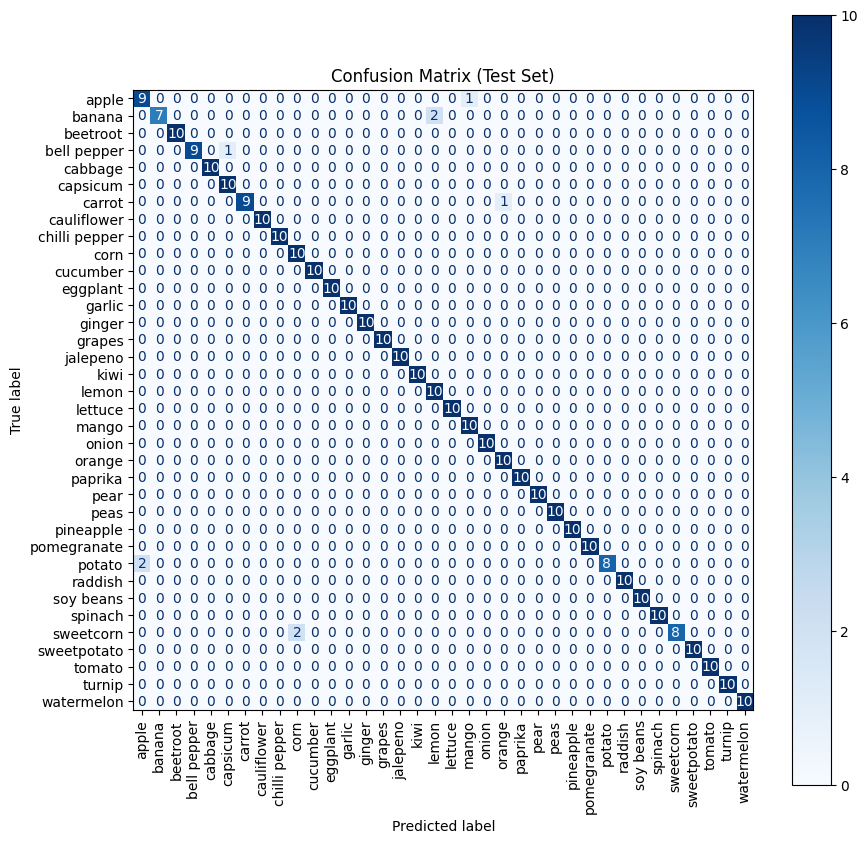

In [ ]:
# Test Dataset Confusion Matrix ÏãúÍ∞ÅÌôî
cm = confusion_matrix(all_labels, all_preds)
class_names = test_loader.dataset.classes

# classification report Ï∂úÎ†•
print(classification_report(all_labels, all_preds, target_names=class_names))

# ÏãúÍ∞ÅÌôî
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()

-------------------
=== Ï∂îÍ∞Ä Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†• ÌÖåÏä§Ìä∏ ÏßÑÌñâ ===

    - Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Î•º ÏûÖÎ†•Ìï¥ ÏòàÏ∏° ÎòêÎäî Î∂ÑÎ•ò Í≤∞Í≥º Ï∂úÎ†•

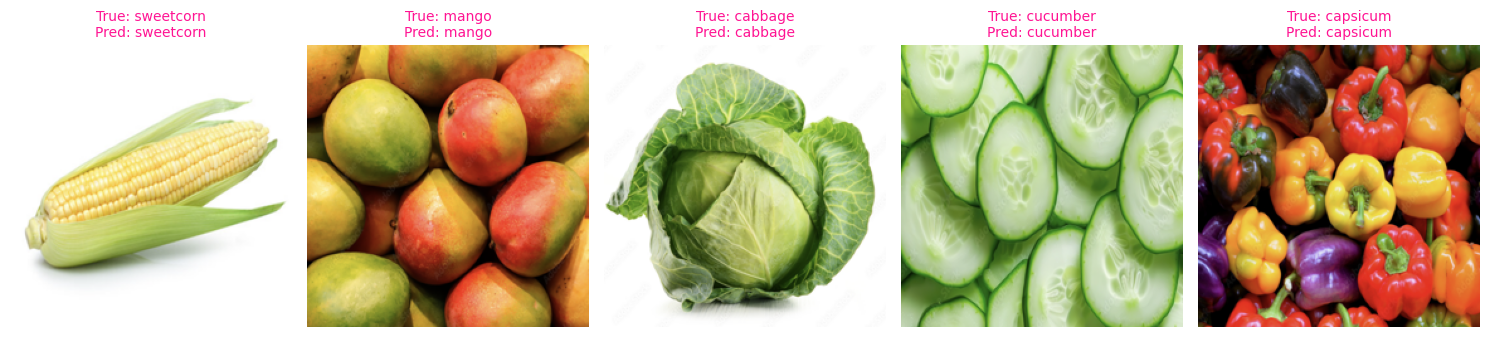

In [ ]:
import torch.nn.functional as F

# Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏
img_paths = [
    "/content/drive/MyDrive/kaggle/sweetcorn.png",
    "/content/drive/MyDrive/kaggle/mango.png",
    "/content/drive/MyDrive/kaggle/cabbage.png",
    "/content/drive/MyDrive/kaggle/cucumber.png",
    "/content/drive/MyDrive/kaggle/capsicum.png"
]

# Î™®Îç∏ ÏòàÏ∏° Î∞è ÏãúÍ∞ÅÌôî
model.eval()

class_names = test_loader.dataset.classes

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, img_path in enumerate(img_paths):
    true_label = os.path.basename(img_path).split('.')[0].lower()

    # Ïù¥ÎØ∏ÏßÄ Î∂àÎü¨Ïò§Í∏∞ Î∞è resize : ÏãúÍ∞ÅÌôîÏö© Ïù¥ÎØ∏ÏßÄÎèÑ 224x224Î°ú ÎßûÏ∂§
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_idx = probs.argmax(dim=1).item()

    predicted_label = class_names[pred_idx]
    title_color = 'deeppink' if true_label == predicted_label else 'royalblue'

    # Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10, color=title_color)

plt.tight_layout()
plt.show()

--------------
=== DB Ïó∞Îèô ===

- SQLiteÏóêÏÑú ÏßÅÏ†ë MySQLÎ°ú ÎßàÏù¥Í∑∏Î†àÏù¥ÏÖò

        ÏïûÏÑú Íµ¨Í∏Ä ÎìúÎùºÏù¥Î∏åÏóê Ï†ÄÏû•Ìïú performance_data.pkl ÌååÏùºÏùÑ DBÏóê Ï†ÄÏû•ÌïòÎäî Î∞©ÏãùÏúºÎ°ú ÏßÑÌñâÌïòÎ©¥ Ï¢ãÏùÑ Í≤É Í∞ôÎã§.  
        train, valid Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú accuracyÏôÄ loss Í∞íÏùÑ Ï†ÄÏû•ÌïòÏó¨ Í¥ÄÎ¶¨Ìï† Ïàò ÏûàÎã§.  

In [ ]:
# Íµ¨Í∏Ä ÎìúÎùºÏù¥Î∏å ÎßàÏö¥Ìä∏
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3
import pickle

In [ ]:
# pickle ÌååÏùº Î°úÎìú
with open("/content/drive/MyDrive/kaggle/performance_data.pkl", 'rb') as f:
    performance_data = pickle.load(f)

In [ ]:
# SQLite DB Ïó∞Í≤∞ (ÏóÜÏúºÎ©¥ ÏûêÎèô ÏÉùÏÑ±Îê®)
conn = sqlite3.connect('/content/drive/MyDrive/kaggle/model_metrics.db')
cursor = conn.cursor()

In [ ]:
# ÌÖåÏù¥Î∏î ÏÉùÏÑ±
cursor.execute('''
    CREATE TABLE IF NOT EXISTS performance (
        epoch INTEGER PRIMARY KEY,
        train_accuracy REAL,
        val_accuracy REAL,
        train_loss REAL,
        val_loss REAL
    )
''')

In [ ]:
# Îç∞Ïù¥ÌÑ∞ ÏÇΩÏûÖ
for epoch in range(len(performance_data['train_accuracies'])):
    cursor.execute('''
        INSERT INTO performance (epoch, train_accuracy, val_accuracy, train_loss, val_loss)
        VALUES (?, ?, ?, ?, ?)
    ''', (
        epoch + 1,
        performance_data['train_accuracies'][epoch],
        performance_data['val_accuracies'][epoch],
        performance_data['train_losses'][epoch],
        performance_data['val_losses'][epoch]
    ))


In [ ]:
# Ï†ÄÏû• Î∞è Ï¢ÖÎ£å
conn.commit()
conn.close()
print("ÏÑ±Îä• Îç∞Ïù¥ÌÑ∞ DBÏóê Ï†ÄÏû• ÏôÑÎ£å")

üìä ÏÑ±Îä• Îç∞Ïù¥ÌÑ∞ DBÏóê Ï†ÄÏû• ÏôÑÎ£å!


In [17]:
conn = sqlite3.connect('/content/drive/MyDrive/kaggle/model_metrics.db')
cursor = conn.cursor()

# ÌÖåÏù¥Î∏î Î™©Î°ù ÌôïÏù∏
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("ÏÉùÏÑ±Îêú ÌÖåÏù¥Î∏î Î™©Î°ù:")
for table in tables:
    print(" -", table[0])

# performance ÌÖåÏù¥Î∏î Íµ¨Ï°∞ ÌôïÏù∏
cursor.execute("PRAGMA table_info(performance);")
columns = cursor.fetchall()

print("\nÌÖåÏù¥Î∏î Íµ¨Ï°∞:")
for col in columns:
    print(f" - Column: {col[1]} | Type: {col[2]}")

ÏÉùÏÑ±Îêú ÌÖåÏù¥Î∏î Î™©Î°ù:
 - performance

ÌÖåÏù¥Î∏î Íµ¨Ï°∞:
 - Column: epoch | Type: INTEGER
 - Column: train_accuracy | Type: REAL
 - Column: val_accuracy | Type: REAL
 - Column: train_loss | Type: REAL
 - Column: val_loss | Type: REAL


In [19]:
cursor.execute("SELECT * FROM performance;")
rows = cursor.fetchall()

print("Ï†ÄÏû•Îêú Îç∞Ïù¥ÌÑ∞:")
for row in rows:
    print(row)


Ï†ÄÏû•Îêú Îç∞Ïù¥ÌÑ∞:
(1, 54.47833065810594, 88.03418803418803, 2.151753524633554, 1.0587957067923113)
(2, 82.11878009630819, 91.45299145299145, 1.1991165185586, 0.9728676351633939)
(3, 89.66292134831461, 96.01139601139602, 1.0047374178201725, 0.8908318172801625)
(4, 94.34991974317818, 95.44159544159544, 0.8850136078321017, 0.8579314351081848)
(5, 96.37239165329053, 96.01139601139602, 0.8336357361231095, 0.8459914164109663)
(6, 93.25842696629213, 95.44159544159544, 0.9085827858020098, 0.8788693709806963)
(7, 94.8314606741573, 96.86609686609687, 0.8857054037925525, 0.8351851620457389)
(8, 96.72552166934189, 96.86609686609687, 0.8229895741511614, 0.8327939429066398)
(9, 97.88121990369181, 97.15099715099716, 0.7917162488668393, 0.7932811704548922)
(10, 98.29855537720707, 96.58119658119658, 0.7678831635377346, 0.8027781817046079)
(11, 98.71589085072232, 97.43589743589743, 0.7492248550439492, 0.779024289412932)
(12, 99.13322632423755, 97.15099715099716, 0.7319671957920759, 0.772038229487159

In [20]:
import pandas as pd

df = pd.read_sql("SELECT * FROM performance", sqlite3.connect('/content/drive/MyDrive/kaggle/model_metrics.db'))
df

epoch  train_accuracy  val_accuracy  train_loss  val_loss
0       1       54.478331     88.034188    2.151754  1.058796
1       2       82.118780     91.452991    1.199117  0.972868
2       3       89.662921     96.011396    1.004737  0.890832
3       4       94.349920     95.441595    0.885014  0.857931
4       5       96.372392     96.011396    0.833636  0.845991
5       6       93.258427     95.441595    0.908583  0.878869
6       7       94.831461     96.866097    0.885705  0.835185
7       8       96.725522     96.866097    0.822990  0.832794
8       9       97.881220     97.150997    0.791716  0.793281
9      10       98.298555     96.581197    0.767883  0.802778
10     11       98.715891     97.435897    0.749225  0.779024
11     12       99.133226     97.150997    0.731967  0.772038
12     13       99.133226     97.150997    0.729001  0.761121
13     14       99.293740     97.720798    0.720026  0.764985
14     15       99.261637     97.720798    0.716541  0.758102
15     16       98.041734     96.866097    0.766175  0.809454
16     17       97.367576     95.726496    0.801698  0.839839
17     18       98.266453     97.150997    0.772861  0.786823